In [1]:
%%bash
pip install timm onnx onnxruntime -q

In [2]:
import os
import cv2
import timm
import onnx
import torch
import pickle
import random as r
import numpy as np
import pandas as pd
import onnxruntime as ort
import matplotlib.pyplot as plt

from typing import Union
from torchvision import transforms
from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore")

In [3]:
labels: dict = {
    0 : "cup",
    1 : "fork",
    2 : "glass",
    3 : "knife",
    4 : "plate",
    5 : "spoon"
}
classifier = pickle.load(open("/kaggle/input/kc-swin-features-train/models/swin_large_patch4_window12_384_in22k_lgr_1.pkl", "rb"))    
    

def breaker() -> None:print("\n" + 50*"*" + "\n")

    
def get_image(
    path: str, 
) -> np.ndarray:
    image = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.cvtColor(src=image, code=cv2.COLOR_BGR2RGB)


def show_image(
    image: np.ndarray, 
    cmap: str="gnuplot2", 
    title: Union[str, None]=None
) -> None:
    plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title: plt.title(title)
    plt.show()

In [4]:
class FeatureExtractorONNX(object):
    def __init__(self) -> None:
        self.ort_session = None
        self.size: int = 384
        
        self.mean: list = [0.52184, 0.47946, 0.43919]
        self.std: list  = [0.17009, 0.17413, 0.17846]
        
        self.path: str = "/kaggle/input/swin-features-onnx/swin_large_patch4_window12_384_in22k.onnx"

        ort.set_default_logger_severity(3)
    
    def setup(self) -> None:
        model = onnx.load(self.path)
        onnx.checker.check_model(model)
        self.ort_session = ort.InferenceSession(self.path)
    
    def infer(self, image: np.ndarray) -> np.ndarray:
        image = image / 255
        image = cv2.resize(src=image, dsize=(self.size, self.size), interpolation=cv2.INTER_AREA).transpose(2, 0, 1)
        for i in range(image.shape[0]): image[i, :, :] = (image[i, :, :] - self.mean[i]) / self.std[i]
        image = np.expand_dims(image, axis=0)
        inputs = {self.ort_session.get_inputs()[0].name : image.astype("float32")}
        return self.ort_session.run(None, inputs)[0].squeeze()[-1, :]

feature_extractor_onnx = FeatureExtractorONNX()
feature_extractor_onnx.setup()

In [5]:
class FeatureExtractorPT(torch.nn.Module):
    def __init__(self) -> None:
        super(FeatureExtractorPT, self).__init__()
        
        self.model = timm.create_model("swin_large_patch4_window12_384_in22k", pretraind=True)
        self.model = torch.nn.Sequential(*[*self.model.children()][:-1])
        
        self.size = 384
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.52184, 0.47946, 0.43919], [0.17009, 0.17413, 0.17846])
        ])
        
        
    def forward(self, x):
        return self.model(x)

    def infer(self, image: np.ndarray):
        self.to(self.device)
        self.eval()
        image = cv2.resize(src=image, dsize=(self.size, self.size), interpolation=cv2.INTER_AREA)
        with torch.no_grad(): features = self(self.transform(image).unsqueeze(dim=0).to(self.device))
        return features.detach().cpu().numpy().squeeze()[-1, :]

        
feature_extractor_pt = FeatureExtractorPT()
feature_extractor_pt.eval()

clear_output()


**************************************************



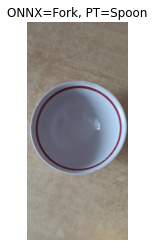


**************************************************



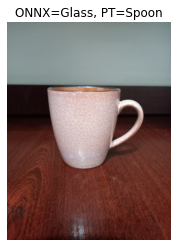


**************************************************



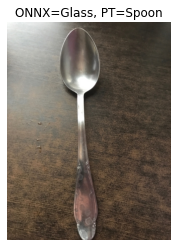


**************************************************



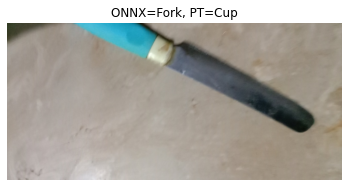


**************************************************



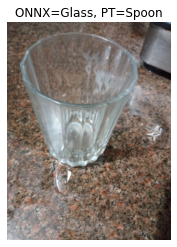


**************************************************



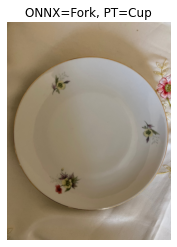


**************************************************



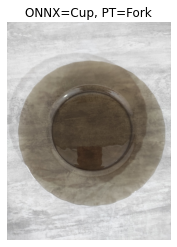


**************************************************



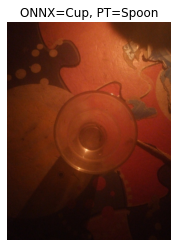


**************************************************



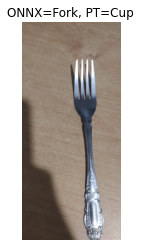


**************************************************



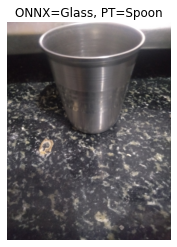


**************************************************



In [6]:
df = pd.read_csv("/kaggle/input/kc-dataframe/test.csv")

breaker()
for _ in range(10):
    index = r.randint(0, df.shape[0] - 1)
    
    filepath = df.iloc[index, 0]
    
    image = get_image(filepath)
    
    features_onnx = feature_extractor_onnx.infer(image)
    y_pred_onnx   = labels[classifier.predict(features_onnx.reshape(1, -1))[0]].title()
    
    features_pt = feature_extractor_pt.infer(image)
    y_pred_pt   = labels[classifier.predict(features_pt.reshape(1, -1))[0]].title()
        
    show_image(image, title=f"ONNX={y_pred_onnx}, PT={y_pred_pt}")
    
    breaker()